In [544]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree
from imblearn.over_sampling import SMOTE
import numpy as np

RANDOM_STATE = 42
CRITERION = 'gini'


In [545]:
df = pd.read_csv('./gameandgrade.csv')
df.head()

,Sex,School Code,Playing Years,Playing Often,Playing Hours,Playing Games,Parent Revenue,Father Education,Mother Education,Grade
0,0,1,1,2,1,1,4,4,5,77.50
1,1,1,1,3,1,1,1,3,3,83.00
2,0,1,0,0,0,0,1,3,3,80.00
3,0,1,3,5,1,1,2,2,3,45.00
4,1,1,1,1,2,1,1,3,4,85.00


In [546]:
def grade_rule(grade):
    grade.strip()
    grade = float(grade)
    if grade >= 90:
        return 'A'
    elif grade >= 80:
        return 'B'
    elif grade >= 70:
        return 'C'
    elif grade >= 60:
        return 'D'
    else:
        return 'F'

categories = ['Good', 'Not bad', 'Bad']
def mark_category(mark):
    if mark in ['A', 'B']:
        return 'Good'
    if mark in ['C', 'D']:
        return 'Not bad'
    return 'Bad'

In [547]:
#У дата сеті присутнє значення для Grade 92..00
df['Grade'] = df['Grade'].str.replace(r'..', '.')
df = df.drop(columns=['School Code'])
df['mark'] = df['Grade'].apply(grade_rule)
df['Mark Category'] = df['mark'].apply(mark_category)

df.drop(columns=['Grade'], inplace=True)
df.drop(columns=['mark'], inplace=True)
df.drop()
df.head()

,Sex,Playing Years,Playing Often,Playing Hours,Playing Games,Parent Revenue,Father Education,Mother Education,Mark Category
0,0,1,2,1,1,4,4,5,Not bad
1,1,1,3,1,1,1,3,3,Good
2,0,0,0,0,0,1,3,3,Good
3,0,3,5,1,1,2,2,3,Bad
4,1,1,1,2,1,1,3,4,Good


In [548]:
df['Is good'] = df['Mark Category'].apply(lambda x: 1 if x == 'Good' else 0)
df['Is bad'] = df['Mark Category'].apply(lambda x: 1 if x == 'Bad' else 0)

In [549]:
X_train_good, X_test_good, y_train_good, y_test_good = (
    train_test_split(df.drop(columns=['Mark Category', 'Is good', 'Is bad']),
                     df['Is good'], random_state=RANDOM_STATE))

In [550]:
clf_good = tree.DecisionTreeClassifier(criterion=CRITERION, random_state=RANDOM_STATE, max_depth=5, max_leaf_nodes=30)
clf_good.fit(X_train_good, y_train_good)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=30, random_state=42)

In [551]:
path = clf_good.cost_complexity_pruning_path(X_train_good, y_train_good)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

alpha_values = {}
ccp_alphas = np.unique(ccp_alphas)

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=alpha, random_state=RANDOM_STATE, criterion=CRITERION)
    clf.fit(X_train_good, y_train_good)
    y_pred = clf.predict(X_test_good)
    print('Accuracy: ', accuracy_score(y_test_good, y_pred), 'Alpha: ', alpha)
    alpha_values[alpha] = accuracy_score(y_test_good, y_pred)

best = max(alpha_values, key=alpha_values.get)

Accuracy:  0.5906735751295337 Alpha:  0.0
Accuracy:  0.5854922279792746 Alpha:  0.00027650634236422783
Accuracy:  0.5803108808290155 Alpha:  0.0006684822975984144
Accuracy:  0.5854922279792746 Alpha:  0.0008223740102626786
Accuracy:  0.5854922279792746 Alpha:  0.0009598720170643903
Accuracy:  0.5958549222797928 Alpha:  0.0012324282688234156
Accuracy:  0.5958549222797928 Alpha:  0.0012498333555525949
Accuracy:  0.5958549222797928 Alpha:  0.0013721945795518737
Accuracy:  0.6010362694300518 Alpha:  0.0019403409351416278
Accuracy:  0.6010362694300518 Alpha:  0.0019575223442777935
Accuracy:  0.5906735751295337 Alpha:  0.0024768919699595625
Accuracy:  0.5906735751295337 Alpha:  0.0025629889993330213
Accuracy:  0.5958549222797928 Alpha:  0.002662995233946086
Accuracy:  0.6269430051813472 Alpha:  0.002835759862642496
Accuracy:  0.6269430051813472 Alpha:  0.0029191941074523525
Accuracy:  0.6269430051813472 Alpha:  0.0034605733955110074
Accuracy:  0.6683937823834197 Alpha:  0.005699061367096983


In [552]:
clf_good = DecisionTreeClassifier(ccp_alpha=best, criterion=CRITERION, random_state=RANDOM_STATE, max_depth=5, max_leaf_nodes=16)
clf_good.fit(X_train_good, y_train_good)

DecisionTreeClassifier(ccp_alpha=0.005699061367096983, max_depth=5,
                       max_leaf_nodes=16, random_state=42)

In [553]:
y_pred_good = clf_good.predict(X_test_good)
print(classification_report(y_test_good, y_pred_good))

              precision    recall  f1-score   support

           0       0.68      0.55      0.61        91
           1       0.66      0.77      0.71       102

    accuracy                           0.67       193
   macro avg       0.67      0.66      0.66       193
weighted avg       0.67      0.67      0.66       193



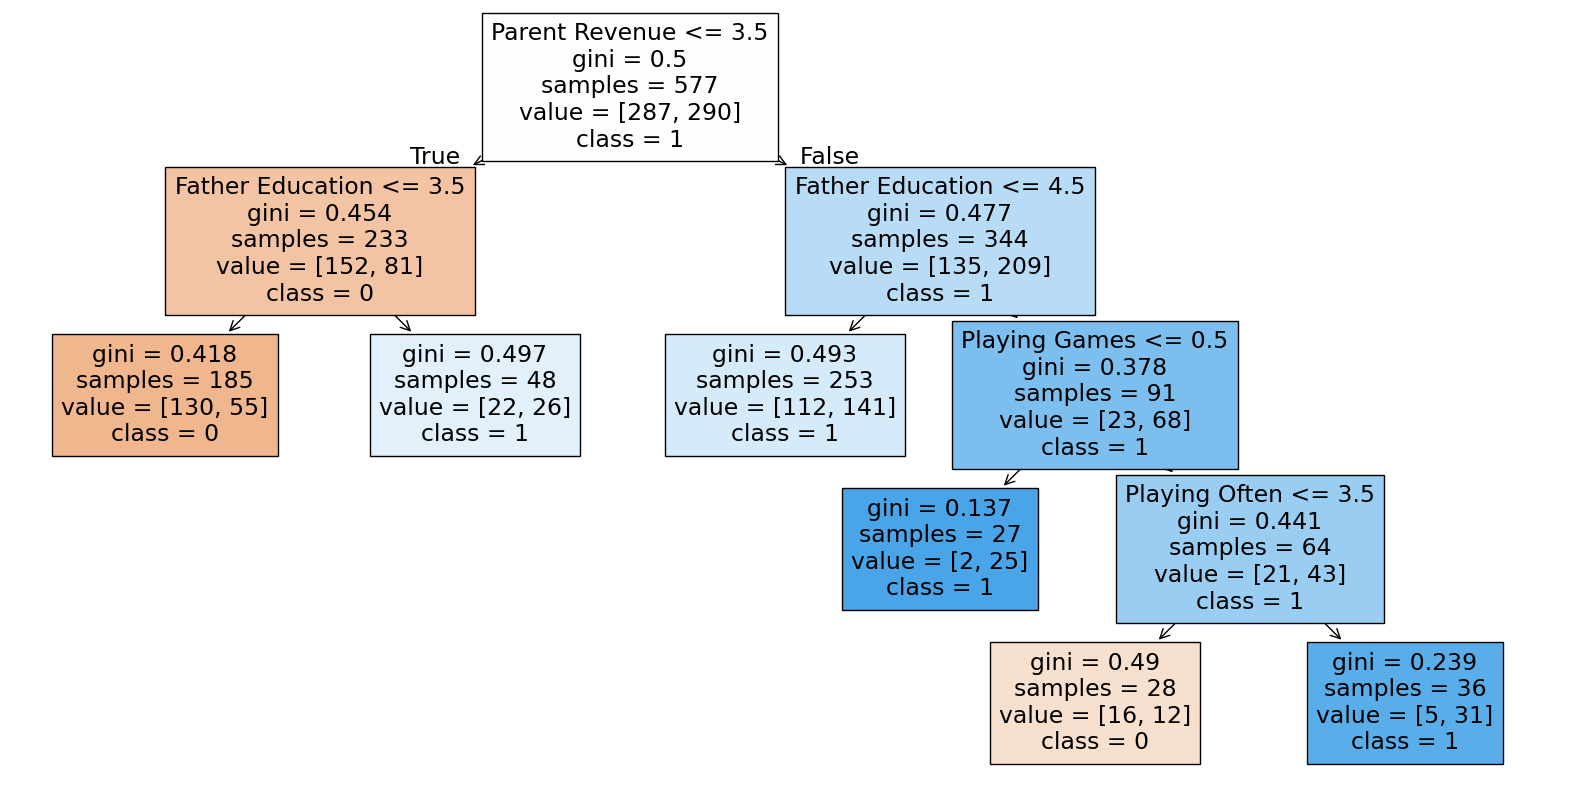

In [554]:
plt.figure(figsize=(20, 10))
tree.plot_tree(clf_good, filled=True, feature_names=df.columns, class_names=df['Is good'].unique().astype(str))
plt.show()